# All Necessary Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
from sklearn.utils import resample
from scipy.special import expit as sigmoid

# Dataset Preprocessing

Encoding and Scaling

In [3]:
def preprocess_data(df, target_column, scaling_type='standard'):
    features = df.drop(target_column, axis=1)
    target = df[target_column]

    non_numeric_columns = features.select_dtypes(exclude=['number']).columns
    numeric_features = list(set(features.columns) - set(non_numeric_columns))
    print(numeric_features)
    print(non_numeric_columns)

    le = LabelEncoder()
    for column in non_numeric_columns:
        if features[column].nunique() == 2:
            features[column] = le.fit_transform(features[column])
        else:
            features[column] = features[column].astype('category')
            
    features = pd.get_dummies(features)
      
    if scaling_type == 'standard':
        scaler = StandardScaler()
    elif scaling_type == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Scaling type must be 'standard' or 'minmax'")
    
    for column in numeric_features:
        features[column] = scaler.fit_transform(features[[column]])

    if target.dtype == 'object':
        target = le.fit_transform(target)
    
    return features, target

20000 negative samples and all positive sample

In [4]:
def select_sample(df, target_column='Class', random_seed=42):
    positive_samples = df[df[target_column] == 1]
    negative_samples = df[df[target_column] == 0]
    
    negative_sample_subset = negative_samples.sample(n=20000, random_state=random_seed)
    subset_df = pd.concat([positive_samples, negative_sample_subset], axis=0)

    return subset_df


Top n correlated features

In [5]:
def top_n_correlated_features(features_df, target_series, n=20):
    if not isinstance(target_series, pd.Series):
        target_series = pd.Series(target_series)
        
    corr_series = features_df.corrwith(target_series)
    top_n = corr_series.abs().sort_values(ascending=False).head(n)
    
    return top_n

## Telco Dataset

In [6]:
telco_df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
telco_df.shape

(7043, 21)

In [8]:
telco_df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [9]:
print(telco_df['TotalCharges'].dtype)

object


In [10]:
# Convert non-numeric values to NaN
telco_df['TotalCharges'] = pd.to_numeric(telco_df['TotalCharges'], errors='coerce')

In [11]:
print(telco_df['TotalCharges'].dtype)

float64


In [12]:
telco_df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [13]:
telco_df['TotalCharges'] = telco_df['TotalCharges'].fillna(telco_df['TotalCharges'].median())

In [14]:
print(telco_df['TotalCharges'].dtype)

float64


In [15]:
telco_df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [16]:
telco_df = telco_df.drop('customerID', axis=1)

In [17]:
telco_df.duplicated().sum()

22

In [18]:
telco_df[telco_df.duplicated(keep=False)]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
22,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.15,20.15,Yes
100,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.20,20.20,No
542,Female,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.55,19.55,No
646,Male,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,45.70,45.70,Yes
662,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.05,20.05,No
690,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.45,20.45,No
964,Male,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,45.70,45.70,Yes
976,Male,0,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,69.90,69.90,Yes
1243,Male,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,45.30,45.30,Yes
1338,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.15,20.15,Yes


In [19]:
telco_df.drop_duplicates(inplace=True)

In [20]:
telco_df[telco_df.duplicated(keep=False)]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [21]:
telco_df.dropna(subset=['Churn'], inplace=True)

In [22]:
telco_df.shape

(7021, 20)

In [23]:
telco_df.reset_index(drop=True, inplace=True)

In [24]:
preprocessed_telco_features, telco_target = preprocess_data(telco_df, target_column='Churn', scaling_type='standard')

['MonthlyCharges', 'SeniorCitizen', 'tenure', 'TotalCharges']
Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [25]:
preprocessed_telco_features

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,-0.440508,1,0,-1.282728,0,1,-1.164135,-0.997328,False,...,True,False,False,True,False,False,False,False,True,False
1,1,-0.440508,0,0,0.062387,1,0,-0.262811,-0.176347,True,...,True,False,False,False,True,False,False,False,False,True
2,1,-0.440508,0,0,-1.241967,1,1,-0.365914,-0.962760,True,...,True,False,False,True,False,False,False,False,False,True
3,1,-0.440508,0,0,0.510759,0,0,-0.750058,-0.197869,False,...,True,False,False,False,True,False,True,False,False,False
4,0,-0.440508,0,0,-1.241967,1,1,0.194503,-0.943556,True,...,True,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7016,1,-0.440508,1,1,-0.345224,1,1,0.663458,-0.131759,False,...,False,False,True,False,True,False,False,False,False,True
7017,0,-0.440508,1,1,1.611307,1,1,1.275428,2.239996,False,...,False,False,True,False,True,False,False,True,False,False
7018,0,-0.440508,1,1,-0.875118,0,1,-1.172450,-0.857558,False,...,True,False,False,True,False,False,False,False,True,False
7019,1,2.270104,1,0,-1.160445,1,1,0.317562,-0.875151,False,...,True,False,False,True,False,False,False,False,False,True


In [26]:
print(telco_target.dtype)

int32


In [27]:
telco_target.shape

(7021,)

In [28]:
telco_top_features = top_n_correlated_features(preprocessed_telco_features, telco_target, n=30)
telco_top_features_df = preprocessed_telco_features[telco_top_features.index].copy().astype(float)
telco_top_features_df

,Contract_Month-to-month,tenure,OnlineSecurity_No,TechSupport_No,InternetService_Fiber optic,Contract_Two year,PaymentMethod_Electronic check,OnlineBackup_No,DeviceProtection_No,InternetService_No,...,OnlineSecurity_Yes,TechSupport_Yes,Dependents,SeniorCitizen,Partner,PaymentMethod_Credit card (automatic),StreamingMovies_No,StreamingTV_No,InternetService_DSL,PaymentMethod_Bank transfer (automatic)
0,1.0,-1.282728,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-0.440508,1.0,0.0,1.0,1.0,1.0,0.0
1,0.0,0.062387,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,-0.440508,0.0,0.0,1.0,1.0,1.0,0.0
2,1.0,-1.241967,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,-0.440508,0.0,0.0,1.0,1.0,1.0,0.0
3,0.0,0.510759,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,-0.440508,0.0,0.0,1.0,1.0,1.0,1.0
4,1.0,-1.241967,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,-0.440508,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7016,0.0,-0.345224,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,-0.440508,1.0,0.0,0.0,0.0,1.0,0.0
7017,0.0,1.611307,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.440508,1.0,1.0,0.0,0.0,0.0,0.0
7018,1.0,-0.875118,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,-0.440508,1.0,0.0,1.0,1.0,1.0,0.0
7019,1.0,-1.160445,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,2.270104,1.0,0.0,1.0,1.0,0.0,0.0


## Adult dataset

In [29]:
adult_df = pd.read_csv('adult.data', header=None)
adult_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [30]:
adult_df.shape

(32561, 15)

In [31]:
adult_df.describe()

,0,2,4,10,11,12
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [32]:
adult_df.replace(' ?', pd.NA, inplace=True)

In [33]:
adult_df.isnull().sum()

0        0
1     1836
2        0
3        0
4        0
5        0
6     1843
7        0
8        0
9        0
10       0
11       0
12       0
13     583
14       0
dtype: int64

In [34]:
adult_df.fillna(adult_df.mode().iloc[0], inplace=True)

In [35]:
adult_df.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
dtype: int64

In [36]:
adult_df.duplicated().sum()

24

In [37]:
adult_df.columns = [f'col{str(i+1)}' for i in range(len(adult_df.columns))]
adult_df[adult_df.duplicated(keep=False)].sort_values(by=list(adult_df.columns))

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15
17673,19,Private,97261,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,<=50K
18698,19,Private,97261,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,<=50K
6990,19,Private,138153,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K
21318,19,Private,138153,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K
15189,19,Private,146679,Some-college,10,Never-married,Exec-managerial,Own-child,Black,Male,0,0,30,United-States,<=50K
21490,19,Private,146679,Some-college,10,Never-married,Exec-managerial,Own-child,Black,Male,0,0,30,United-States,<=50K
3917,19,Private,251579,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,14,United-States,<=50K
31993,19,Private,251579,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,14,United-States,<=50K
5805,20,Private,107658,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,10,United-States,<=50K
11631,20,Private,107658,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,10,United-States,<=50K


In [38]:
adult_df.drop_duplicates(inplace=True)

In [39]:
adult_df.shape

(32537, 15)

In [40]:
adult_df.reset_index(drop=True, inplace=True)

In [41]:
preprocessed_adult_features, adult_target = preprocess_data(adult_df, target_column='col15', scaling_type='minmax')

['col12', 'col5', 'col11', 'col13', 'col3', 'col1']
Index(['col2', 'col4', 'col6', 'col7', 'col8', 'col9', 'col10', 'col14'], dtype='object')


In [42]:
preprocessed_adult_features.shape

(32537, 104)

In [43]:
print(adult_target.dtype)

int32


In [44]:
preprocessed_adult_features

,col1,col3,col5,col10,col11,col12,col13,col2_ Federal-gov,col2_ Local-gov,col2_ Never-worked,...,col14_ Portugal,col14_ Puerto-Rico,col14_ Scotland,col14_ South,col14_ Taiwan,col14_ Thailand,col14_ Trinadad&Tobago,col14_ United-States,col14_ Vietnam,col14_ Yugoslavia
0,0.301370,0.044302,0.800000,1,0.021740,0.0,0.397959,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,0.452055,0.048238,0.800000,1,0.000000,0.0,0.122449,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,0.287671,0.138113,0.533333,1,0.000000,0.0,0.397959,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,0.493151,0.151068,0.400000,1,0.000000,0.0,0.397959,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,0.150685,0.221488,0.800000,0,0.000000,0.0,0.397959,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32532,0.136986,0.166404,0.733333,0,0.000000,0.0,0.377551,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32533,0.315068,0.096500,0.533333,1,0.000000,0.0,0.397959,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32534,0.561644,0.094827,0.533333,0,0.000000,0.0,0.397959,False,False,False,...,False,False,False,False,False,False,False,True,False,False
32535,0.068493,0.128499,0.533333,1,0.000000,0.0,0.193878,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [45]:
adult_target

array([0, 0, 0, ..., 0, 0, 1])

In [46]:
adult_top_features = top_n_correlated_features(preprocessed_adult_features, adult_target, n=30)
adult_top_features_df = preprocessed_adult_features[adult_top_features.index].copy().astype(float)
adult_top_features_df

,col6_ Married-civ-spouse,col8_ Husband,col5,col6_ Never-married,col1,col13,col8_ Own-child,col11,col10,col7_ Exec-managerial,...,col6_ Divorced,col2_ Private,col8_ Wife,col7_ Prof-specialty,col7_ Adm-clerical,col9_ Black,col7_ Handlers-cleaners,col4_ 11th,col9_ White,col8_ Other-relative
0,0.0,0.0,0.800000,1.0,0.301370,0.397959,0.0,0.021740,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,1.0,0.800000,0.0,0.452055,0.122449,0.0,0.000000,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.533333,0.0,0.287671,0.397959,0.0,0.000000,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,1.0,0.400000,0.0,0.493151,0.397959,0.0,0.000000,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,1.0,0.0,0.800000,0.0,0.150685,0.397959,0.0,0.000000,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32532,1.0,0.0,0.733333,0.0,0.136986,0.377551,0.0,0.000000,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32533,1.0,1.0,0.533333,0.0,0.315068,0.397959,0.0,0.000000,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32534,0.0,0.0,0.533333,0.0,0.561644,0.397959,0.0,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
32535,0.0,0.0,0.533333,1.0,0.068493,0.193878,1.0,0.000000,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Adult test dataset

In [47]:
adult_test_df = pd.read_csv('adult.test', header=None, skiprows=1)
adult_test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [48]:
adult_test_df.shape

(16281, 15)

In [49]:
adult_test_df.replace(' ?', pd.NA, inplace=True)

In [50]:
adult_test_df.isnull().sum()

0       0
1     963
2       0
3       0
4       0
5       0
6     966
7       0
8       0
9       0
10      0
11      0
12      0
13    274
14      0
dtype: int64

In [51]:
adult_test_df.fillna(adult_df.mode().iloc[0], inplace=True)

In [52]:
adult_test_df.isnull().sum()

0       0
1     963
2       0
3       0
4       0
5       0
6     966
7       0
8       0
9       0
10      0
11      0
12      0
13    274
14      0
dtype: int64

In [53]:
adult_test_df.duplicated().sum()

5

In [54]:
adult_test_df.columns = [f'col{str(i+1)}' for i in range(len(adult_test_df.columns))]
adult_test_df[adult_test_df.duplicated(keep=False)].sort_values(by=list(adult_test_df.columns))

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15
3900,18,Self-emp-inc,378036,12th,8,Never-married,Farming-fishing,Own-child,White,Male,0,0,10,United-States,<=50K.
15960,18,Self-emp-inc,378036,12th,8,Never-married,Farming-fishing,Own-child,White,Male,0,0,10,United-States,<=50K.
488,24,Private,194630,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,35,United-States,<=50K.
864,24,Private,194630,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,35,United-States,<=50K.
9249,29,Private,36440,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K.
11212,29,Private,36440,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K.
7021,30,Private,180317,Assoc-voc,11,Divorced,Machine-op-inspct,Not-in-family,White,Male,0,0,40,United-States,<=50K.
13848,30,Private,180317,Assoc-voc,11,Divorced,Machine-op-inspct,Not-in-family,White,Male,0,0,40,United-States,<=50K.
1319,37,Private,52870,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K.
11189,37,Private,52870,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K.


In [55]:
adult_test_df.drop_duplicates(inplace=True)

In [56]:
adult_test_df.duplicated().sum()

0

In [57]:
adult_test_df.shape

(16276, 15)

In [58]:
adult_test_df.reset_index(drop=True, inplace=True)

In [59]:
preprocessed_adult_test_features, adult_test_target = preprocess_data(adult_test_df, target_column='col15', scaling_type='standard')

['col12', 'col5', 'col11', 'col13', 'col3', 'col1']
Index(['col2', 'col4', 'col6', 'col7', 'col8', 'col9', 'col10', 'col14'], dtype='object')


In [60]:
preprocessed_adult_test_features.shape

(16276, 103)

In [61]:
adult_test_target

array([0, 0, 1, ..., 0, 0, 1])

In [62]:
adult_test_features = preprocessed_adult_test_features[adult_top_features.index].copy().astype(float)
adult_test_features

,col6_ Married-civ-spouse,col8_ Husband,col5,col6_ Never-married,col1,col13,col8_ Own-child,col11,col10,col7_ Exec-managerial,...,col6_ Divorced,col2_ Private,col8_ Wife,col7_ Prof-specialty,col7_ Adm-clerical,col9_ Black,col7_ Handlers-cleaners,col4_ 11th,col9_ White,col8_ Other-relative
0,0.0,0.0,-1.196669,1.0,-0.994356,-0.031615,1.0,-0.142684,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,1.0,-0.417699,0.0,-0.055664,0.769762,0.0,-0.142684,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,1.0,0.750757,0.0,-0.777734,-0.031615,0.0,-0.142684,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.0,-0.028214,0.0,0.377579,-0.031615,0.0,0.870916,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,-0.028214,1.0,-1.499805,-0.832992,1.0,-0.142684,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16271,0.0,0.0,1.140242,0.0,0.016543,-0.352166,0.0,-0.142684,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
16272,0.0,0.0,-0.417699,0.0,1.821720,-0.031615,0.0,-0.142684,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
16273,1.0,1.0,1.140242,0.0,-0.055664,0.769762,0.0,-0.142684,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
16274,0.0,0.0,1.140242,0.0,0.377579,-0.031615,1.0,0.576513,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Credit card dataset

In [63]:
credit_df = pd.read_csv('creditcard.csv')
credit_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [64]:
credit_df.shape

(284807, 31)

In [65]:
credit_df = select_sample(credit_df, target_column='Class', random_seed=42)

In [66]:
credit_df.shape

(20492, 31)

In [67]:
credit_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,...,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000
mean,94597.371706,-0.107762,0.083454,-0.160491,0.099235,-0.054706,-0.037981,-0.130745,0.022703,-0.049350,...,0.011981,0.002161,-0.000376,-0.005244,-0.004795,0.003627,0.004931,0.002602,87.204299,0.024009
std,47419.488734,2.256356,1.771030,2.088620,1.603466,1.612071,1.343215,1.775434,1.518074,1.211827,...,0.901877,0.743675,0.628494,0.607795,0.530127,0.484613,0.446501,0.323199,218.972909,0.153082
min,0.000000,-30.552380,-32.494845,-31.103685,-4.938824,-22.105532,-17.282140,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.836627,-4.781606,-1.581931,-9.543518,-8.307955,0.000000,0.000000
25%,54363.000000,-0.954126,-0.590673,-0.981190,-0.821735,-0.709887,-0.790661,-0.590015,-0.204629,-0.670004,...,-0.224958,-0.546528,-0.166939,-0.353197,-0.320637,-0.327495,-0.070438,-0.052950,5.000000,0.000000
50%,84583.500000,-0.020377,0.084821,0.142395,0.014180,-0.064729,-0.289011,0.028145,0.028596,-0.058014,...,-0.023321,0.009036,-0.011281,0.038190,0.013083,-0.042754,0.002560,0.012017,21.500000,0.000000
75%,139101.500000,1.297729,0.846832,0.998194,0.810935,0.625504,0.387316,0.571085,0.349109,0.591750,...,0.193370,0.529610,0.152043,0.432866,0.348356,0.249352,0.096813,0.081911,77.267500,0.000000
max,172768.000000,2.420346,22.057729,3.893024,12.155016,28.516513,15.323769,15.915767,20.007208,8.294218,...,27.202839,8.361985,17.751731,4.016342,5.852484,3.517346,9.879903,15.870474,6511.000000,1.000000


In [68]:
credit_df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [69]:
credit_df.duplicated().sum()

22

In [70]:
credit_df[credit_df.duplicated(keep=False)].sort_values(by=list(credit_df.columns))

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
102441,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,...,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
102442,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,...,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
102443,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,...,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
102444,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,...,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
102445,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,...,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
102446,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,...,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
141259,84204.0,-1.927453,1.827621,-7.019495,5.348303,-2.739188,-2.107219,-5.015848,1.205868,-4.382713,...,1.376938,-0.792017,-0.771414,-0.379574,0.718717,1.111151,1.277707,0.819081,512.25,1
141260,84204.0,-1.927453,1.827621,-7.019495,5.348303,-2.739188,-2.107219,-5.015848,1.205868,-4.382713,...,1.376938,-0.792017,-0.771414,-0.379574,0.718717,1.111151,1.277707,0.819081,512.25,1
141257,84204.0,-0.937843,3.462889,-6.445104,4.932199,-2.233983,-2.291561,-5.695594,1.338825,-4.322377,...,1.066550,-0.521657,-0.319917,-0.405859,0.906802,1.165784,1.374495,0.729889,0.00,1
141258,84204.0,-0.937843,3.462889,-6.445104,4.932199,-2.233983,-2.291561,-5.695594,1.338825,-4.322377,...,1.066550,-0.521657,-0.319917,-0.405859,0.906802,1.165784,1.374495,0.729889,0.00,1


In [71]:
credit_df.drop_duplicates(inplace=True)

In [72]:
credit_df.duplicated().sum()

0

In [73]:
credit_df.reset_index(drop=True, inplace=True)

In [74]:
preprocessed_credit_features, credit_target = preprocess_data(credit_df, target_column='Class', scaling_type='standard')

['V5', 'V22', 'V16', 'V9', 'V15', 'V14', 'V26', 'V27', 'V10', 'V21', 'V25', 'V17', 'V20', 'V23', 'V1', 'V13', 'V2', 'Amount', 'V6', 'V8', 'Time', 'V7', 'V11', 'V12', 'V4', 'V18', 'V19', 'V3', 'V24', 'V28']
Index([], dtype='object')


In [75]:
preprocessed_credit_features.shape

(20470, 30)

In [76]:
credit_target

0        1
1        1
2        1
3        1
4        1
        ..
20465    0
20466    0
20467    0
20468    0
20469    0
Name: Class, Length: 20470, dtype: int64

In [77]:
credit_top_features = top_n_correlated_features(preprocessed_credit_features, credit_target, n=20)
credit_top_features_df = preprocessed_credit_features[credit_top_features.index].copy().astype(float)
credit_top_features_df

,V14,V12,V17,V10,V16,V3,V11,V7,V4,V18,V9,V1,V2,V5,V6,V19,V8,V21,V20,V27
0,-2.755772,-1.883212,-1.672746,-1.777868,-0.898203,-0.720939,2.596648,-1.428654,2.453390,0.027847,-2.266392,-0.999369,1.076050,-0.299287,-1.037686,0.474825,0.979282,0.649744,0.158762,0.586035
1,-1.026630,-0.259437,0.454162,-0.480854,0.642748,0.609065,-0.412328,0.261118,1.379366,1.805457,-0.187210,-1.329237,-1.852916,0.887341,-0.767438,0.314612,-0.071249,0.833231,2.844000,-0.594485
2,-0.878878,-4.362957,-2.883102,-0.941540,-1.871308,-0.104759,1.623953,0.400849,1.405505,-2.623903,-0.160005,-0.995365,0.965557,-0.488089,-0.028516,-1.625279,-0.309761,-0.380836,-0.598288,0.077047
3,-4.408098,-7.311845,-7.730409,-3.139060,-6.198599,-1.205459,4.005879,-1.994561,1.625143,-5.191005,-0.167921,-1.940170,0.735747,-0.681344,-1.246871,0.344577,-0.201524,0.721305,-0.247020,-1.913851
4,-3.947548,-3.041524,4.261558,-1.560008,2.275382,-2.049186,1.680887,1.080264,2.915161,3.149444,-1.029075,0.600305,1.688149,2.315081,-0.986285,-3.288929,-0.379736,-0.488672,-0.001434,-0.036848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20465,0.174081,-0.120751,-0.526102,0.181093,0.426707,-0.242830,-0.262019,0.093655,-0.694345,0.390518,-0.101431,-0.283600,0.104490,1.700478,2.401957,0.287949,0.509139,-0.025245,-0.229507,-1.357684
20466,0.236048,-0.432650,0.029779,-0.152110,-0.313731,-0.111998,-1.839710,0.345789,-0.235194,0.006629,0.419135,0.113256,0.335734,0.349626,-0.132111,0.673616,-0.661952,1.180299,-0.542767,0.198685
20467,0.062383,0.642300,-0.426661,0.170121,0.790651,0.053592,0.611327,-0.546644,0.046317,0.564009,1.004715,0.887339,-0.450796,-0.494927,0.252003,-0.144157,0.195455,0.121853,-0.155605,-0.073326
20468,0.831942,-0.798254,0.508269,-0.335494,-0.242604,0.400593,0.365705,0.085713,0.607979,-0.569102,1.316192,0.568842,0.057200,-0.217614,-0.433799,-0.032377,-0.241524,-0.444457,-0.012931,-0.122023


# Training the Model

## Train-test train-val split

In [78]:
def split_data(features, target, test_size=0.2, validation_size=0.2, random_seed=42):
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=test_size, random_state=random_seed
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=validation_size, random_state=random_seed
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [79]:
def train_val_split(features, target, validation_size=0.2, random_seed=42):
    X_train, X_val, y_train, y_val = train_test_split(
        features, target, test_size=validation_size, random_state=random_seed
    )
    return X_train, X_val, y_train, y_val

## Bagging 

In [80]:
def bagging(X_train, y_train, target_column, num_models=9):
    examples = pd.concat([X_train, y_train], axis=1)
    train_Sets = []
    for i in range(num_models):
        samples = examples.sample(frac=1, replace=True)
        train_Sets.append(tuple([samples.drop(target_column, axis=1), samples[[target_column]].copy()]))
        
    X_sets = [train_set[0] for train_set in train_Sets]
    y_sets = [train_set[1] for train_set in train_Sets]
    
    return X_sets, y_sets

## Sigmoid function & LR training

In [81]:
def sigmoid_function(z):
    return 1 / (1 + np.exp(-z))    # match probability to [0, 1]

def train_logistic_regression(X, y, regularization='l1', learning_rate=0.6, n_iters=50):
    beta = 0.1
    # X = X.to_numpy()
    y = y.to_numpy().flatten()
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    bias = 0
    
    for i in range(n_iters):
        linear_model = np.dot(X, weights) + bias
        y_predicted = sigmoid_function(linear_model)
        
        # Compute gradients
        error = y_predicted - y
        gradient_weights = (1 / n_samples) * np.dot(X.T, error)
        gradient_bias = (1 / n_samples) * np.sum(error)
        
        # Apply regularization
        if regularization == 'l2':
            gradient_weights += (beta / n_samples) * weights
        elif regularization == 'l1':
            gradient_weights += (beta / n_samples) * np.sign(weights)

        # Update weights and bias
        weights -= learning_rate * gradient_weights
        bias -= learning_rate * gradient_bias

        #decaying learning rate
        if i%10 == 0:
            learning_rate = learning_rate*0.9

    return weights, bias


## Prediction

In [82]:
def predict_logistic_regression(X, weights, bias):
    linear_model = np.dot(X, weights) + bias
    y_predicted = sigmoid_function(linear_model)
    return [1 if i >= 0.5 else 0 for i in y_predicted]

## Majority Voting

In [83]:
def majority_voting(models, X_test):
    # Get predictions for each model in the ensemble & generating 2D array
    all_predictions = np.array([predict_logistic_regression(X_test, weights, bias) for (weights, bias) in models])
    # Majority vote for each sample
    final_predictions = np.round(np.mean(all_predictions, axis=0)).astype(int)
    return final_predictions

## Stacking

In [84]:
def stacking(models, X_meta_train, y_meta_train, X_test):
    # Train meta-classifier X_val
    meta_train_predictions = np.array([predict_logistic_regression(X_meta_train, weights, bias) for weights, bias in models]).T
    #print(meta_train_predictions.shape)
    meta_weights, meta_bias = train_logistic_regression(meta_train_predictions, y_meta_train)
    # Test predictions 9xsamples
    
    test_predictions = np.array([predict_logistic_regression(X_test, weights, bias) for weights, bias in models]).T
    stacking_predictions = predict_logistic_regression(test_predictions, meta_weights, meta_bias)
    stacking_probs = sigmoid_function(np.dot(test_predictions, meta_weights) + meta_bias) 

    return stacking_predictions, stacking_probs

In [85]:
def predict_proba_voting(models, X_test):
    all_probs = np.array([sigmoid_function(np.dot(X_test, weights) + bias) for (weights, bias) in models])
    # Average the predicted probabilities across models
    avg_probs = np.mean(all_probs, axis=0)
    return avg_probs


## Performance matrix calculation

In [86]:
def compute_performance_metrics(pred_y, true_y, prob_y=None):
    tn, fp, fn, tp = confusion_matrix(true_y, pred_y).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
    f1 = f1_score(true_y, pred_y)  # F1 Score
    auroc, aupr = None, None

    if prob_y is not None:
        auroc = roc_auc_score(true_y, prob_y)
        aupr = average_precision_score(true_y, prob_y)

    return {
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'F1-Score': f1,
        'AUROC': auroc,
        'AUPR': aupr
    }

## Violin plotting

In [87]:
def draw_violin_plots(performance_metrics_list, metrics_names):
    data = {metric: [] for metric in metrics_names}
    for metrics in performance_metrics_list:
        for metric in metrics_names:
            data[metric].append(metrics[metric])

    plot_data = pd.DataFrame(data) # Convert to DataFrame for seaborn
    plot_data = plot_data.melt(var_name='Metric', value_name='Value')
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='Metric', y='Value', data=plot_data, inner='quartile')
    plt.title('Violin Plots of Performance Metrics')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Final pipeline

In [88]:
def main_pipeline(X_train, X_val, X_test, y_train, y_val, y_test, target_column):
    X_bagged, y_bagged = bagging(X_train, y_train, target_column, num_models=9)
    models = []
    regularizers = ['l1', 'l2']  

    for i in range(9):
        regularizer = regularizers[i % len(regularizers)]  # Rotate through L1 and L2 regularization
        weights, bias = train_logistic_regression(X_bagged[i], y_bagged[i], regularization=regularizer)
        models.append((weights, bias))

    voting_predictions = majority_voting(models, X_test)    # Voting ensemble
    voting_probs = predict_proba_voting(models, X_test)
    voting_metrics = compute_performance_metrics(voting_predictions, y_test, voting_probs)

    stacking_predictions, stacking_probs = stacking(models, X_val, y_val, X_test)    # Stacking ensemble
    stacking_metrics = compute_performance_metrics(stacking_predictions, y_test, stacking_probs)

    performance_metrics_list = []
    for i, (weights, bias) in enumerate(models):
        base_pred = predict_logistic_regression(X_test, weights, bias)
        base_probs = sigmoid_function(np.dot(X_test, weights) + bias)  # Assuming sigmoid returns probabilities
        base_metrics = compute_performance_metrics(base_pred, y_test, base_probs)
        performance_metrics_list.append(base_metrics)
    
    # Calculate average and standard deviation across all models for each metric
    metrics_names = list(performance_metrics_list[0].keys())
    metrics_array = {metric: [] for metric in metrics_names}
    
    for metrics in performance_metrics_list:
        for metric in metrics_names:
            metrics_array[metric].append(metrics[metric])
            
    avg_std_table = pd.DataFrame(columns=metrics_names, index=["LR*", "Voting ensemble", "Stacking ensemble"])
    for metric in metrics_names:
        avg = np.mean(metrics_array[metric])
        std = np.std(metrics_array[metric])
        avg_std_table.loc["LR*", metric] = f"{avg:.4f} ± {std:.4f}"

    for metric, value in voting_metrics.items():
        avg_std_table.loc["Voting ensemble", metric] = f"{value:.4f}"

    for metric, value in stacking_metrics.items():
        avg_std_table.loc["Stacking ensemble", metric] = f"{value:.4f}"

    draw_violin_plots(performance_metrics_list, metrics_names)
    return avg_std_table

## Training on Telco

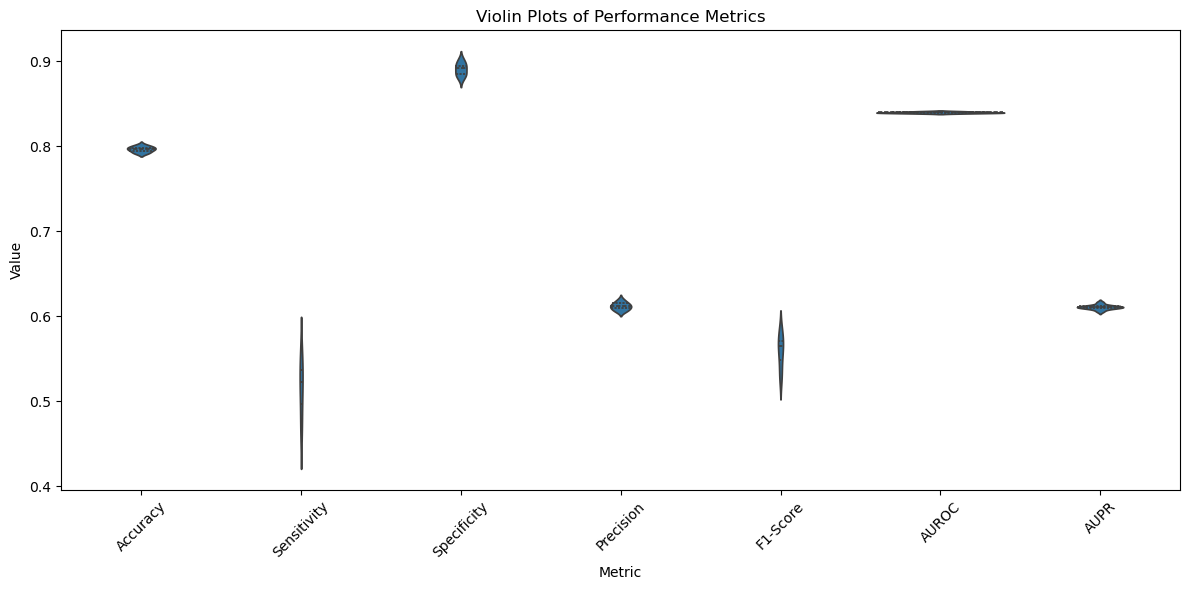

In [89]:
telco_target = pd.DataFrame(telco_target, columns=['Churn'])
X_train, X_val, X_test, y_train, y_val, y_test = split_data(telco_top_features_df, telco_target)
avg_std_table = main_pipeline(X_train, X_val, X_test, y_train, y_val, y_test, 'Churn')

In [90]:
avg_std_table

,Accuracy,Sensitivity,Specificity,Precision,F1-Score,AUROC,AUPR
LR*,0.7967 ± 0.0030,0.5152 ± 0.0311,0.8908 ± 0.0071,0.6120 ± 0.0041,0.5589 ± 0.0184,0.8399 ± 0.0007,0.6109 ± 0.0025
Voting ensemble,0.7993,0.5227,0.8917,0.6174,0.5662,0.8401,0.6102
Stacking ensemble,0.7964,0.5114,0.8917,0.6122,0.5573,0.7235,0.4582


## Training on Adult dataset

In [91]:
adult_target = pd.DataFrame(adult_target, columns=['col15'])
X_train, X_val, y_train, y_val = train_val_split(adult_top_features_df, adult_target, validation_size=0.2, random_seed=42)
X_test = adult_test_features
y_test = adult_test_target

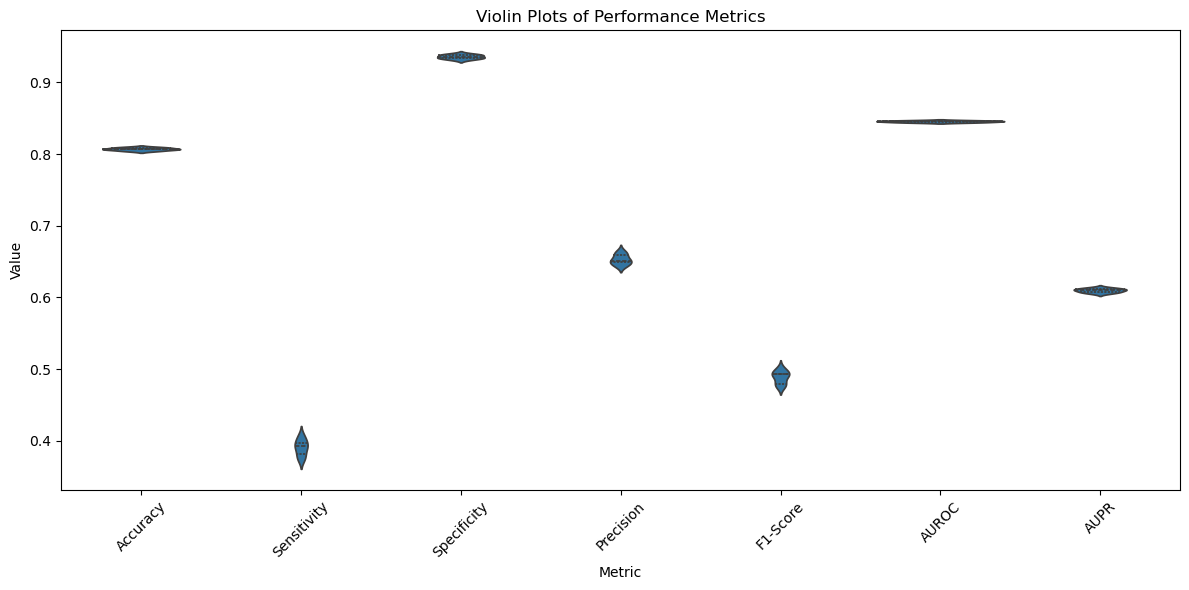

In [92]:
avg_std_table = main_pipeline(X_train, X_val, X_test, y_train, y_val, y_test, 'col15')

In [93]:
avg_std_table

,Accuracy,Sensitivity,Specificity,Precision,F1-Score,AUROC,AUPR
LR*,0.8070 ± 0.0018,0.3909 ± 0.0105,0.9357 ± 0.0026,0.6532 ± 0.0066,0.4890 ± 0.0083,0.8455 ± 0.0010,0.6099 ± 0.0025
Voting ensemble,0.8067,0.3916,0.9352,0.6514,0.4891,0.8456,0.6100
Stacking ensemble,0.8068,0.3804,0.9388,0.6578,0.4820,0.6740,0.4130


## Training on credit dataset

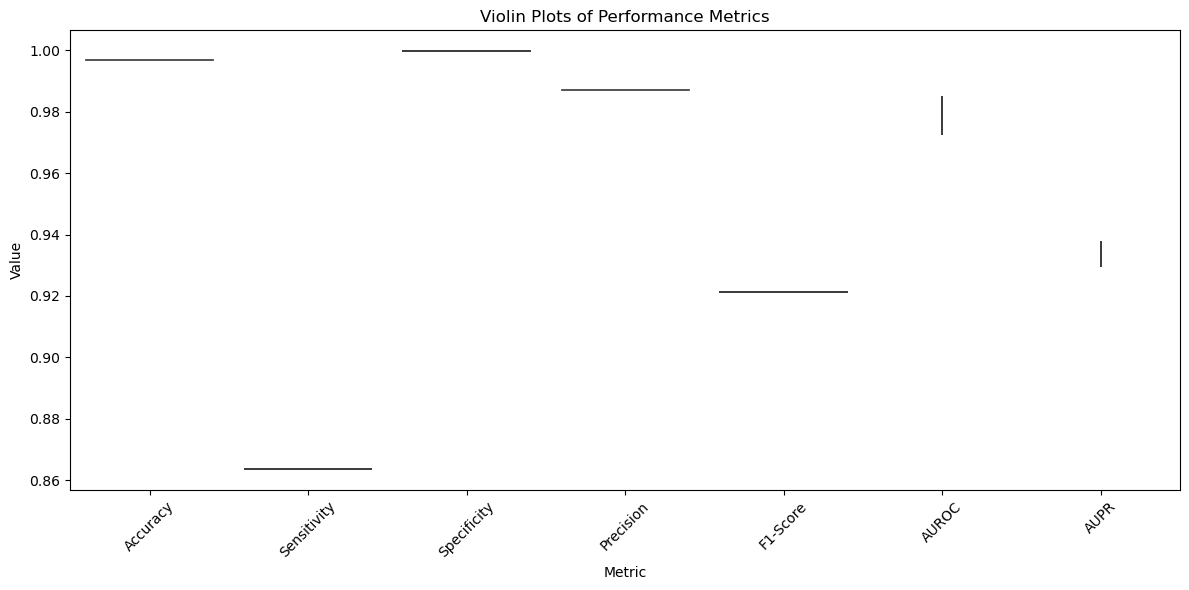

In [94]:
credit_target = pd.DataFrame(credit_target, columns=['Class'])
X_train, X_val, X_test, y_train, y_val, y_test = split_data(credit_top_features_df, credit_target)
avg_std_table = main_pipeline(X_train, X_val, X_test, y_train, y_val, y_test, 'Class')

In [95]:
avg_std_table

,Accuracy,Sensitivity,Specificity,Precision,F1-Score,AUROC,AUPR
LR*,0.9968 ± 0.0000,0.8636 ± 0.0000,0.9998 ± 0.0000,0.9870 ± 0.0000,0.9212 ± 0.0000,0.9787 ± 0.0021,0.9332 ± 0.0013
Voting ensemble,0.9968,0.8636,0.9998,0.9870,0.9212,0.9791,0.9333
Stacking ensemble,0.9785,0.0000,1.0000,0.0000,0.0000,0.9317,0.8554
